Group 20 members:
- Janick Michot:          michojan@students.zhaw.ch
- Andre von Aarburg :     andre.vonaarburg@ost.ch
- Manuel Weiss:           weissman@students.zhaw.ch

In [2]:
import math
import numpy as np
import torch
import torchvision

### Model

A Model here consists of a succession of layers.

Each layer is implemented as a class with the following API-methods:

`forward(torch.tensor)`: Computes the forward pass through the layer, i.e. $x\rightarrow a$<br> and keeps the information needed for computing the backward pass as member variables.
`backward(torch.tensor)`: Computes the backward pass through the layer in form of the derivatives, i.e. $da \rightarrow dx$. On the fly, it also computes the derivatives w.r.t. the parameters of the layer and keeps them as member variables. It assumes that `forward` method has been run before. <br>
`update(lr)`: Updates the parameters of the layer in accordance with vanilla gradient descent and scalar learning rate `lr`. It assumes that the `forward` and the `backward`-pass has been run before.  

The tensors defined as inputs to the `forward`/`backward`-method are two dimensional with the sample index in the first and the the feature index in the second dimension. 

For fully connected layers with activation function $s(\cdot)$ the formulas are given as follows:

__Forward path:__

$X_{i,j}$: Tensor with shape $(n_b,n_x)$ where $n_b$ is the number of samples in the batch and $n_x$ the number of input features (for MNIST: 784).

$Z_{i,j} = \sum_k X_{i,k} W_{j,k} \qquad (Z = X \cdot W^T + b)$ $\qquad$ ($W$ a tensor of shape $(n_h,n_x)$)

$A_{i,j} = s(Z_{i,j}) \qquad\qquad (A = s(Z))$

__Backward path:__ (with $n_b$ the number of samples in a batch)

$dx_{i,k} = \frac{\partial L}{\partial x_{i,k}} = \sum_j \frac{\partial L}{\partial a_{i,j}} \frac{\partial a_{i,j}}{\partial x_{i,k}} = \sum_j da_{i,j} s^\prime(z_{i,j})\cdot \frac{\partial z_{i,j}}{\partial x_{i,k}} = \sum_j da_{i,j} s^\prime(z_{i,j}) W_{j,k}$<br>

$dW_{k,j} = \frac{\partial L}{\partial W_{k,j}} = \frac{1}{n_b}\sum_i da_{i,k}\frac{\partial a_{i,k}}{\partial W_{k,j}} = \frac{1}{n_b}\sum_j da_{i,k} s^\prime(z_{i,k}) \frac{\partial z_{i,k}}{\partial W_{k,j}} = \frac{1}{n_b}\sum_j da_{i,k} s^\prime(z_{i,k}) x_{i,j}$<br>





__Parameter Initialisation__ 

The parameters need to be initialised which will be a topic later in the course. For now use the following rules: 
* weights normally distributed with mean $0$ and stdev $1/\sqrt{n_h}$
* bias initialized with zero values

#### <span style="color:red">Important Note on the Implementation</span>

Make sure that all the tensors used anywhere in the model components below have `requires_grad=False`.
Autograd functionality is not allowed for computing the gradients. - Autograd will be used below for testing whether your implementation is correct.

### Linear Layer

In [3]:
class LinearLayer():
    def __init__(self, nx, nh):
        """
        nx -- number of input features, i.e. shape of input tensors x given by (*,nb_input)
        nh -- number of output features, i.e. shape of output tensor z given by (*,nb_hidden)
        """    
        self.nx = nx
        self.nh = nh
        self.w = torch.empty(nh, nx).normal_(0, 1./math.sqrt(self.nh))
        self.b = torch.zeros(nh)
        self.dw = torch.zeros_like(self.w)
        self.db = torch.zeros_like(self.b)
        self.x = None
        self.dx = None
    
    def forward(self, x):
        """
        Computes the forward pass through the layer
        x -- input tensor
        returns z 
        """
        ### YOUR CODE START ###
        self.x = x
        return x @ self.w.T + self.b
        
        
        ### YOUR CODE END ###
    
    def backward(self, dz):
        """
        Computes the backward pass through the layer incl. the derivatives w.r.t. input x (dx), weight w (dw) and bias b (db).
        dz -- tensor with the backprop'd error signal with the same shape as z.         
        returns dx
        """
        assert len(dz.shape)==2 and dz.shape[1] == self.nh
        ### YOUR CODE START ###
        self.dw = torch.mean(dz.view(-1, self.nh, 1) @ self.x.view(-1, 1, self.nx), dim=0)
        self.db = torch.mean(dz, dim=0)
        self.dx = dz @ self.w
        return self.dx
        ### YOUR CODE END ###
            
    def update(self, lr):
        """
        Updates the parameters of the model (weights w and bias b) with the gradient w.r.t. w and b and learning rate.
        returns None
        """
        ### YOUR CODE START ###

        self.w = self.w - lr * self.dw
        self.b = self.b - lr * self.db
        
        
        ### YOUR CODE END ###



<span style="color:blue">SHAPE TEST:</span>

In [4]:
linear = LinearLayer(3,4)
assert (4,3) == linear.w.shape
assert (4,)  == linear.b.shape

x = torch.tensor([[1.,2,3],[4,5,6]])
a = linear.forward(x)
assert (2,4) == a.shape

dz = torch.tensor([[1.,1,1,1],[2.,2,2,2]])
dx = linear.backward(dz)

print(dx)
assert (2,3) == dx.shape
assert (4,3) == linear.dw.shape

tensor([[-0.4910, -1.2927,  0.7115],
        [-0.9821, -2.5855,  1.4231]])


### Activation Function

__Sigmoid__


In [5]:
class SigmoidActivation():

    def __init__(self):
        self.z = None

    def sigmoid(self, z):
        return 1.0 / (1.0 + torch.exp(-z))
    
    def forward(self, z):
        ### YOUR CODE START ###
        self.z = z
        return self.sigmoid(z)
                
        ### YOUR CODE END ###

    def backward(self, da):
        ### YOUR CODE START ###

        # hand calculated
        # return (torch.exp(self.z) / (torch.exp(self.z) + 1)**2)*da

        #Wikipedia derivative of sigmoid(x) = sigmoid(x)' = (sigmoid(x)/(1-sigmoid(x))
        sig_z = self.sigmoid(self.z)
        return sig_z*(1-sig_z)*da

        ### YOUR CODE END ###
            
    def update(self, lr):
        ### YOUR CODE START ###
        pass
        ### YOUR CODE END ###




### Model

Now implement an MLP as a succession of layers - linear layers and non-linear activation layers.
For creating an instance, you will pass the following arguments:
* nx: number of input features
* nunits: list of number of units in the hidden layers including the output layer

Add a list of layers as member variable.

Use just a linear layer at the end. Further below we will use a CE loss which is based on the finally output logit values (see lecture of week 2) where the softmax probabilities are implicit.

In [6]:
class MLP():
    
    def __init__(self, nx, nunits):
        self.nx = nx
        self.nlayers = len(nunits)
        self.nunits = nunits
        self.nunits.insert(0,nx)
        self.nclasses = self.nunits[-1]
        self.layers = []
        
        ### YOUR CODE START ###
        # instantiate the different layers (linear and activations)



        for layerIdx in range(self.nlayers - 1):
            self.layers.append(LinearLayer(self.nunits[layerIdx], self.nunits[layerIdx + 1]))
            self.layers.append(SigmoidActivation())
        self.layers.append(LinearLayer(self.nunits[self.nlayers - 1], self.nunits[self.nlayers]))
        
        ### YOUR CODE END ###

        
    def forward(self, x):
        """
        x - input tensor        
        returns output tensor of the model
        """
        
        ### YOUR CODE START ###

        for layer in self.layers:
            x = layer.forward(x)

        return  x
        
        ### YOUR CODE END ###
    
    def backward(self, dy):
        """
        dy - derivative w.r.t. output tensor
        
        returns derivative with respect to the input tensor of the model; 
        on the fly compute all the derivatives w.r.t. parameters of the model
        """        
        ### YOUR CODE START ###

        for layer in reversed(self.layers):
            dy = layer.backward(dy)
        
        return dy
        ### YOUR CODE END ###
    
    def update(self, lr):
        """
        Update the parameters with the given (stored) derivatives w.r.t. model parameters by using the given learning rate. 
        """
        ### YOUR CODE START ###
        for layer in self.layers:
            layer.update(lr)
        ### YOUR CODE END ###
            

<span style="color:blue">SHAPE TEST:</span>

In [7]:
nx = 2
nunits = [3,4]
mlp = MLP(nx,nunits)
assert 3 == len(mlp.layers)

x = torch.tensor([[1.,2],[3,4]])
a = mlp.forward(x)
assert (2,4) == a.shape

da = torch.tensor([[1.,1,1,1],[2.,2,2,2]])
dx = mlp.backward(da)
assert (2,2) == dx.shape

nx = 2
nunits = [3,4]
mlp = MLP(nx,nunits)
assert 3 == len(mlp.layers)

x = torch.tensor([[1.,2],[3,4]])
a = mlp.forward(x)
assert (2,4) == a.shape

da = torch.tensor([[1.,1,1,1],[2.,2,2,2]])
dx = mlp.backward(da)
assert (2,2) == dx.shape

### Regression Test

Create a regression testing that allows you to test your implementation by regressing against the gradients computed by pytorch's autograd.

Below you find two functions that may be helpful in 
1. creating a reference model from the given model - makes sure that in the reference model the exact same initialized parameters are used; furthermore, that teh parameters of the linear layers (w,b) are specified as tensors with `requires_grad=True`. 
2. comparing the derivatives w.r.t. parameters for model and refmodel. It assumes that for both, model and refmodel, backprop has been executed. For the model, it means that `backward()`has been executed - for the ref model, only `forward` has been executed, but `backward` applied to the output tensor of the refmodel. For the remodel, we use `grad` of the weights and bias tensors, for the model the parameters `dw` and `db` as basis for the comparison.

<span style="color:red">Adjust these methods to make them compliant with your model - it uses internals of our implementation.</span>

In [8]:
def create_refmodel(model):
    refmodel = MLP(model.nx, model.nunits[1:])
    for i,layer in enumerate(model.layers):
        if isinstance(layer, LinearLayer):
            refmodel.layers[i].w = model.layers[i].w.detach().clone()
            refmodel.layers[i].w.requires_grad_()
            refmodel.layers[i].b = model.layers[i].b.detach().clone()
            refmodel.layers[i].b.requires_grad_()
    return refmodel

def test_params(model, refmodel, digits=8):
    for i,layer in enumerate(model.layers):
        if isinstance(layer, LinearLayer):
            try:
                xxref = refmodel.layers[i].w.grad.detach().numpy()
                xx = model.layers[i].dw.numpy()
                np.testing.assert_array_almost_equal(xx, xxref, decimal=digits, err_msg="Error: layer %i"%i)
                xxref = refmodel.layers[i].b.grad.detach().numpy()
                xx = model.layers[i].db.numpy()
                np.testing.assert_array_almost_equal(xx, xxref, decimal=digits, err_msg="Error: layer %i"%i)

            except Exception as e:
                print("test failed - reason:",e)
    

<span style="color:blue"> REGRESSION TEST</span>

In [9]:
# inputs
nx = 10
x = torch.randn(nx).reshape(-1,nx)

# model instance
nunits = [20,40,1]
mlp = MLP(nx,nunits)

# forward and backward pass
z = mlp.forward(x)
dz = torch.tensor([1.,1.]).reshape(-1,1)
dx = mlp.backward(dz)

# create ref model
mlpref = create_refmodel(mlp)

# only use the forward method of the ref model - and apply backward to the output tensor.
zref = mlpref.forward(x) 
zref.backward()

# compare the derivatives computed by your model with the grad computed by pytorch's autograd
test_params(mlp, mlpref, digits=7)

### Cost 

Use the cross-entropy cost function directly defined on the basis of the logits - which implicitly includes a softmax calculation (see lecture notes of week 2).

In [10]:
class CELoss():
    
    def value(self, z, y):
        """
        z -- tensor of shape (number of samples, number of classes) with the final logits of the model. 
        y -- tensor of shape (number of samples) with the label values.
        """
        ### YOUR CODE START ###
        nb = y.shape[0]

        s = torch.exp(z)
        s_exp_sum = torch.sum(s, dim=1, keepdim=True)
        softmax = s/s_exp_sum
        return -torch.log(softmax[torch.arange(nb),y[:]]).sum()



        ### YOUR CODE END ###

    def derivative(self, z, y):
        ### YOUR CODE START ###
        s = torch.exp(z)
        s_exp_sum = torch.sum(s, dim=1, keepdim=True)
        dsoftmax = s/s_exp_sum

        nb = y.shape[0]
        dsoftmax[torch.arange(nb),y[:]] -= 1.0
        return dsoftmax

        ### YOUR CODE END ###

In [11]:
loss = CELoss()
ypred = torch.log(torch.tensor([[0.5,0.4,0.1],[0.2,0.1,0.7]])).reshape(-1,3) # -> logits z
y = torch.tensor([1,2]).reshape(-1)
np.testing.assert_almost_equal(loss.value(ypred,y), -torch.log(torch.tensor([0.4,0.7])).sum(), decimal=8)
np.testing.assert_array_almost_equal(loss.derivative(ypred,y), torch.tensor([[ 0.5000, -0.6000,  0.1000],[ 0.2000,  0.1000, -0.3000]]), decimal=8)

### Load Data

As in previous' week PW. 

In [12]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [13]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

### Training Loop

Implement mini-batch gradient descent training loop. 

With the implementation of the two methods below you will be able to train and test the MLP:
* train_epoch: for training the model over one epoch with per mini-batch updates
* test_epoch: for evaluating the test/validation performance per epoch.

In [14]:
def train_epoch(model, loss, dataloader, lr):
    """
    Iterate over the mini-batches of one epoch, compute per mini-batch the forward and backward pass 
    and update the parameters. Also compute the loss and accuracy as an average over the epoch. 
    Note that this average includes per mini-batch updated model predictions and parameter updates.
    model -- model to be trained
    loss -- loss function to be used 
    dataloader -- data loader that provides mini-batches (from the training set)
    lr -- learning rate to be used in the parameter updates     
    returns loss, accuracy 
    """
    ### YOUR CODE START ###
    nsamples = len(dataloader.dataset)
    trainloss, correct = 0.0, 0
    for X, y in dataloader:
        batchsize = X.shape[0]
        X = X.view(batchsize, -1)
        z = model.forward(X)
        batchloss = loss.value(z, y)
        trainloss += batchloss.item()
        correct += (z.argmax(dim=1) == y).type(torch.float).sum().item()

        # Backpropagation
        dz = loss.derivative(z,y)
        dx = model.backward(dz)
        model.update(lr)
    trainloss /= nsamples
    correct /= nsamples
    return trainloss, correct
    ### YOUR CODE START ###


def test_epoch(model, loss, dataloader):
    """
    Iterate over the mini-batches of one epoch of the test set. Iterates over the mini-batches of the test set.
    Estimates loss and accuracy as an average over the test (validation) set. The model is not updates here. 
    model -- model to be evaluated
    loss -- loss function to be evaluated 
    dataloader -- data loader that provides mini-batches (from the test/validation set)
    returns loss, accuracy 
    """
    nsamples = len(dataloader.dataset)
    testloss, correct = 0.0, 0
    for X, y in dataloader:
        batchsize = X.shape[0]
        X = X.view(batchsize, -1)
        z = model.forward(X)
        testloss += loss.value(z, y)
        correct += (z.argmax(dim=1) == y).type(torch.float).sum().item()

    testloss /= nsamples
    correct /= nsamples
    return testloss, correct


### First Simple Check: Overfitting on Single Sample

Load an arbitrary mini-batch from the training set. Train the model by using just this mini-batch.
This is another test for checking whether your implementation is capable of learning something (see remark in week 2 of the course).

In [15]:
sample_batch, _ = torch.utils.data.random_split(train_data, [64, 60000-64])
train_loader = DataLoader(sample_batch, batch_size=64, shuffle=False) # shuffling not needed since only one batch is used.

sample_x,sample_y = next(iter(train_loader))
print(sample_x.shape,sample_y.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [14]:
epochs = 100
lr = 1.0
mlp = MLP(28*28, [100, 10])
mseloss = CELoss()
trainlosses = []
trainaccs = []
for t in range(epochs):
    trainloss, trainacc = train_epoch(mlp, mseloss, train_loader, lr)
    trainlosses.append(trainloss)
    trainaccs.append(trainacc)
    if t%10==0:
        print(f"Epoch: {t}, Train Accuracy: {(100*trainacc):>0.1f}%, Train Loss: {trainloss:>8f}")

Epoch: 0, Train Accuracy: 15.6%, Train Loss: 3.027420
Epoch: 10, Train Accuracy: 95.3%, Train Loss: 0.429841
Epoch: 20, Train Accuracy: 100.0%, Train Loss: 0.159812
Epoch: 30, Train Accuracy: 100.0%, Train Loss: 0.096210
Epoch: 40, Train Accuracy: 100.0%, Train Loss: 0.067210
Epoch: 50, Train Accuracy: 100.0%, Train Loss: 0.051017
Epoch: 60, Train Accuracy: 100.0%, Train Loss: 0.040810
Epoch: 70, Train Accuracy: 100.0%, Train Loss: 0.033841
Epoch: 80, Train Accuracy: 100.0%, Train Loss: 0.028804
Epoch: 90, Train Accuracy: 100.0%, Train Loss: 0.025008


Text(0.5, 1.0, 'Train Accuracy')

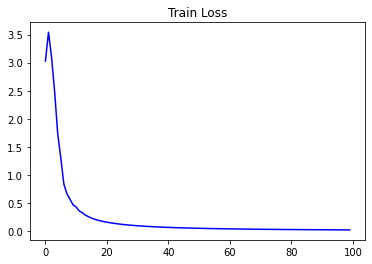

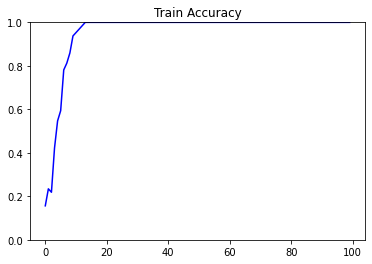

In [15]:
plt.figure(1)
plt.plot(torch.arange(epochs), trainlosses,"b-")
plt.title("Train Loss")

plt.figure(2)
plt.plot(torch.arange(epochs), trainaccs,"b-")
plt.ylim([0.0,1])
plt.title("Train Accuracy")

### Training with all the training set

In [16]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

In [17]:
epochs = 10
lr = 1.0
mlp = MLP(28*28, [100,10])
mseloss = CELoss()
trainlosses, testlosses = [],[]
trainaccs, testaccs = [],[]

for epoch in range(epochs):
    trainloss, trainacc = train_epoch(mlp, mseloss, train_loader, lr)
    testloss, testacc = test_epoch(mlp, mseloss, test_loader)
    trainlosses.append(trainloss)
    testlosses.append(testloss)
    trainaccs.append(trainacc)
    testaccs.append(testacc)
    print(f"Epoch: {epoch}, Train Accuracy: {(100*trainacc):>0.1f}%, Train Loss: {trainloss:>8f}, Test Accuracy: {(100*testacc):>0.1f}%, Test Loss: {testloss:>8f}")

Epoch: 0, Train Accuracy: 90.7%, Train Loss: 0.327613, Test Accuracy: 93.4%, Test Loss: 0.215559
Epoch: 1, Train Accuracy: 95.4%, Train Loss: 0.152928, Test Accuracy: 96.0%, Test Loss: 0.130066
Epoch: 2, Train Accuracy: 96.7%, Train Loss: 0.112299, Test Accuracy: 96.8%, Test Loss: 0.104839
Epoch: 3, Train Accuracy: 97.4%, Train Loss: 0.088315, Test Accuracy: 96.9%, Test Loss: 0.099994
Epoch: 4, Train Accuracy: 97.8%, Train Loss: 0.073687, Test Accuracy: 97.4%, Test Loss: 0.088385
Epoch: 5, Train Accuracy: 98.1%, Train Loss: 0.063230, Test Accuracy: 97.3%, Test Loss: 0.082389
Epoch: 6, Train Accuracy: 98.5%, Train Loss: 0.054160, Test Accuracy: 97.5%, Test Loss: 0.080677
Epoch: 7, Train Accuracy: 98.7%, Train Loss: 0.046642, Test Accuracy: 97.6%, Test Loss: 0.077925
Epoch: 8, Train Accuracy: 98.9%, Train Loss: 0.041263, Test Accuracy: 97.4%, Test Loss: 0.084327
Epoch: 9, Train Accuracy: 99.0%, Train Loss: 0.036174, Test Accuracy: 97.8%, Test Loss: 0.071364


Text(0.5, 1.0, 'Accuracy')

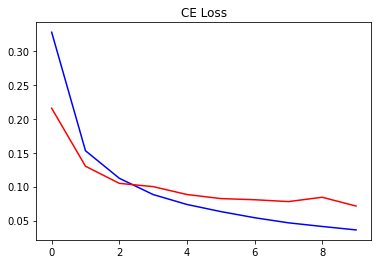

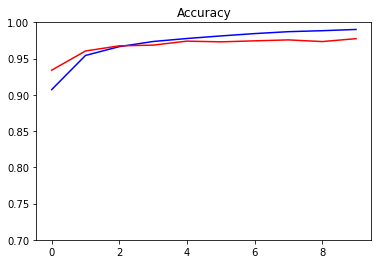

In [18]:
plt.figure(1)
plt.plot(torch.arange(epochs), trainlosses,"b-")
plt.plot(torch.arange(epochs), testlosses,"r-")
plt.title("CE Loss")

plt.figure(2)
plt.plot(torch.arange(epochs), trainaccs,"b-")
plt.plot(torch.arange(epochs), testaccs,"r-")
plt.ylim([0.7,1])
plt.title("Accuracy")


Epoch: 0, Train Accuracy: 71.4%, Train Loss: 0.930641, Test Accuracy: 89.0%, Test Loss: 0.374347
Epoch: 1, Train Accuracy: 90.1%, Train Loss: 0.336556, Test Accuracy: 91.7%, Test Loss: 0.285997
Epoch: 2, Train Accuracy: 91.9%, Train Loss: 0.274065, Test Accuracy: 93.0%, Test Loss: 0.240888
Epoch: 3, Train Accuracy: 93.2%, Train Loss: 0.231107, Test Accuracy: 93.9%, Test Loss: 0.206496
Epoch: 4, Train Accuracy: 94.1%, Train Loss: 0.199578, Test Accuracy: 94.7%, Test Loss: 0.181595
Epoch: 5, Train Accuracy: 94.9%, Train Loss: 0.174033, Test Accuracy: 95.2%, Test Loss: 0.163009
Epoch: 6, Train Accuracy: 95.4%, Train Loss: 0.154795, Test Accuracy: 95.2%, Test Loss: 0.160807
Epoch: 7, Train Accuracy: 95.9%, Train Loss: 0.139001, Test Accuracy: 95.6%, Test Loss: 0.148840
Epoch: 8, Train Accuracy: 96.3%, Train Loss: 0.125598, Test Accuracy: 96.1%, Test Loss: 0.130525
Epoch: 9, Train Accuracy: 96.7%, Train Loss: 0.112994, Test Accuracy: 95.9%, Test Loss: 0.134691
Epoch: 10, Train Accuracy: 97.

Text(0.5, 1.0, 'Accuracy')

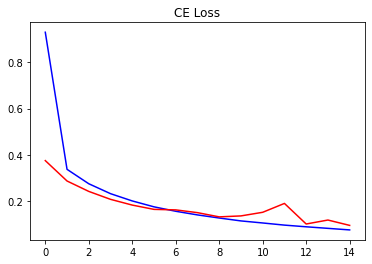

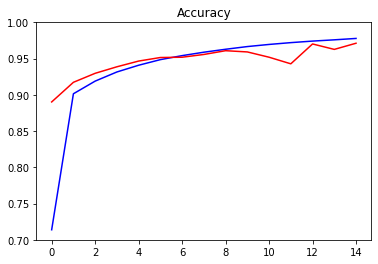

In [17]:
epochs = 15
lr = 0.23
mlp = MLP(28*28, [200,100,60,10])
mseloss = CELoss()
trainlosses, testlosses = [],[]
trainaccs, testaccs = [],[]

for epoch in range(epochs):
    trainloss, trainacc = train_epoch(mlp, mseloss, train_loader, lr)
    testloss, testacc = test_epoch(mlp, mseloss, test_loader)
    trainlosses.append(trainloss)
    testlosses.append(testloss)
    trainaccs.append(trainacc)
    testaccs.append(testacc)
    print(f"Epoch: {epoch}, Train Accuracy: {(100*trainacc):>0.1f}%, Train Loss: {trainloss:>8f}, Test Accuracy: {(100*testacc):>0.1f}%, Test Loss: {testloss:>8f}")

plt.figure(1)
plt.plot(torch.arange(epochs), trainlosses,"b-")
plt.plot(torch.arange(epochs), testlosses,"r-")
plt.title("CE Loss")

plt.figure(2)
plt.plot(torch.arange(epochs), trainaccs,"b-")
plt.plot(torch.arange(epochs), testaccs,"r-")
plt.ylim([0.7,1])
plt.title("Accuracy")

### Autograd from exercise 2  

In [18]:
class MLP_Ex2(torch.nn.Module):
    
    def __init__(self, units, activation_class = None):
        super(MLP_Ex2, self).__init__()
        if not activation_class:
            activation_class = torch.nn.Sigmoid
        self.units = units
        layers = [torch.nn.Flatten()]
        for i in range(len(units)-2):
            layers.append(torch.nn.Linear(units[i], units[i+1]))
            layers.append(activation_class())
        layers.append(torch.nn.Linear(units[-2],units[-1]))
        self.layers = torch.nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

In [19]:
def train_test(model, lr, nepochs, nbatch, train_loader, test_loader):
    # finally return the sequence of per epoch values
    cost_hist_test = []
    cost_hist_train = []
    acc_hist_test = []
    acc_hist_train = []

    cost_ce = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    # epoch: current epoch
    # cost, cost_valid, acc, acc_valid: cost and acurracy (for training, validation set) per epoch     
    
    for epoch in range(nepochs):
        size_train = len(train_loader.dataset)
        nbatches_train = len(train_loader)
        size_test = len(test_loader.dataset)
        nbatches_test = len(test_loader)
        cost_train, acc_train = 0.0, 0.0
        for batch, (X,Y) in enumerate(train_loader):
            pred = model(X)
            loss = cost_ce(pred,Y)
            cost_train += loss.item()
            acc_train += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        cost_train /= nbatches_train
        acc_train /= size_train
        cost_test, acc_test = 0.0, 0.0
        with torch.no_grad():
            for X,Y in test_loader:
                pred = model(X)
                cost_test += cost_ce(pred, Y).item()
                acc_test += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()
        cost_test /= nbatches_test
        acc_test /= size_test
        
        print("Epoch: %i | Cost_train: %f | Acc_train: %f | Cost_test: %f | Acc_test: %f"%(epoch, cost_train, acc_train, cost_test, acc_test))
        ### YOUR CODE END ###
        
        cost_hist_train.append(cost_train)
        cost_hist_test.append(cost_test)
        acc_hist_train.append(acc_train)
        acc_hist_test.append(acc_test)
        
    plt.figure(1)
    plt.plot(torch.arange(nepochs), cost_hist_train, "-")
    plt.plot(torch.arange(nepochs), cost_hist_test, "r-")
    plt.xlabel("Epoch")
    plt.xlim(0,nepochs)
    plt.title("Cross-Entropy Cost")
    plt.figure(2)
    plt.plot(torch.arange(nepochs), acc_hist_train,"-")
    plt.plot(torch.arange(nepochs), acc_hist_test,"r-")
    plt.xlabel("Epoch")
    plt.xlim(0,nepochs)
    plt.title("Accuracy")
    #return cost_hist, cost_hist_valid, acc_hist, acc_hist_valid

Epoch: 0 | Cost_train: 2.308995 | Acc_train: 0.106500 | Cost_test: 2.310345 | Acc_test: 0.101000
Epoch: 1 | Cost_train: 2.043115 | Acc_train: 0.232500 | Cost_test: 1.344778 | Acc_test: 0.499000
Epoch: 2 | Cost_train: 0.868416 | Acc_train: 0.711633 | Cost_test: 0.615292 | Acc_test: 0.811600
Epoch: 3 | Cost_train: 0.508968 | Acc_train: 0.856617 | Cost_test: 0.459918 | Acc_test: 0.869200
Epoch: 4 | Cost_train: 0.394100 | Acc_train: 0.889500 | Cost_test: 0.351987 | Acc_test: 0.898500
Epoch: 5 | Cost_train: 0.313714 | Acc_train: 0.911750 | Cost_test: 0.293312 | Acc_test: 0.917900
Epoch: 6 | Cost_train: 0.251360 | Acc_train: 0.928917 | Cost_test: 0.231377 | Acc_test: 0.934600
Epoch: 7 | Cost_train: 0.208819 | Acc_train: 0.940250 | Cost_test: 0.225288 | Acc_test: 0.933700
Epoch: 8 | Cost_train: 0.178491 | Acc_train: 0.948233 | Cost_test: 0.180699 | Acc_test: 0.948200
Epoch: 9 | Cost_train: 0.157039 | Acc_train: 0.954750 | Cost_test: 0.186432 | Acc_test: 0.945600
Epoch: 10 | Cost_train: 0.1388

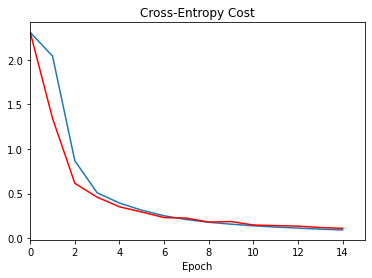

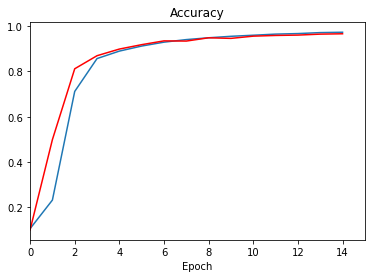

In [20]:
Input_Hidden_Output = [28*28,200,100,60,10]
lr = 0.23
nepochs = 15
nbatch = 64

train_test(MLP_Ex2(Input_Hidden_Output), lr, nepochs, nbatch, train_loader, test_loader)

| Units | nepochs | lr | Acc (Train) | Acc (Valid) |
| --- | :-: | :-: | :-: | :-: |
| (784,200,100,60,10) autograd | 15 | 0.23 | 97.3% | 96.6% |
| (784,200,100,60,10) manual backprop | 15 | 0.23 | 97.8% | 97.1% |

It is visible that the two models aim at the same value. The initially lower value of the autograd model is attributed to the fact that the standard deviation of W in this model was not introduced with $1/\sqrt{n_h}$. However, this has hardly any influence on the last Epoch.

Interstingly our manualy backprop is more accurate than the autograd function of pytroch. Is that possible?